In [35]:
import ast
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [85]:
pd.options.display.max_columns = 99
plt.rcParams['figure.figsize'] = (16, 9)

# Data Preparation

## Load Data

In [3]:
df_train = pd.read_csv('data/train.csv', index_col='id')
df_test = pd.read_csv('data/test.csv', index_col='id')
print(df_train.shape, df_test.shape)
df_train.head()

(3000, 22) (4398, 21)


,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
id,,,,,,,,,,,,,,,,,,,,,,
1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


## Prepare Columns

### Dictionary Columns

Some of the columns contain one or more dictionaries as strings. First, convert them to Python objects.

In [4]:
dict_cols = ['belongs_to_collection', 'genres', 'production_companies', 'production_countries',
             'spoken_languages', 'Keywords', 'cast', 'crew']

def prepare_dict_cols(df, dict_cols=dict_cols):
    for col in dict_cols:
        df[col] = df[col].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))
    return df

df_train = prepare_dict_cols(df_train)
df_text = prepare_dict_cols(df_test)

#### belongs_to_collection

Create columns that capture if a film belongs to a collection.

In [5]:
def prepare_belongs_to_collection(df):
    df['collection_name'] = df['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else np.NaN)
    df['has_collection'] = df['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)
    df.drop('belongs_to_collection', axis=1, inplace=True)
    return df

df_train = prepare_belongs_to_collection(df_train)
df_test = prepare_belongs_to_collection(df_test)

#### genres

Create function for inspecting dictionary columns and apply to genres.

In [14]:
def inspect_and_prepare_dict_col(col, df_train=df_train, df_test=df_test, top=15, prepare=True):
    print("\tValue counts for number of items in each row:")
    print(df_train[col].apply(lambda x: len(x) if x != {} else 0).value_counts())
    print()
    
    print("\tMost common {} items in {}:".format(top, col))
    counts = Counter()
    items = df_train[col].apply(lambda x: [i['name'] for i in x] if x != {} else []).values
    for item in items:
        for v in item:
            counts[v] += 1
    for k, v in counts.most_common(top):
        print(k, v)
    print("\tTotal number of unique values: {}".format(len(counts)))
    print()
    
    # Prepare columns
    top_c = counts.most_common(top)
    all_c = counts.keys()

    if prepare:
        df_train[col] = items
        df_test[col] = df_test[col].apply(lambda x: [i['name'] for i in x] if x != {} else [])
        df_train['num_%s' % col] = df_train[col].apply(lambda x: len(x) if x != {} else 0)
        df_test['num_%s' % col] = df_test[col].apply(lambda x: len(x) if x != {} else 0)        
        df_train['%s_other' % col] = 0
        df_test['%s_other' % col] = 0
        for item in all_c:
            if item in [k for k,v in top_c] and item != '':
                df_train[col + item] = df_train[col].apply(lambda x: 1 if item in x else 0)
                df_test[col + item] = df_test[col].apply(lambda x: 1 if item in x else 0)
            else:
                df_train['%s_other' % col] += df_train[col].apply(lambda x: 1 if item in x else 0)
                df_test['%s_other' % col] += df_test[col].apply(lambda x: 1 if item in x else 0)
        df_train.drop(col, axis=1, inplace=True)
        df_test.drop(col, axis=1, inplace=True)
    
    return df_train, df_test

In [6]:
df_train, df_test = inspect_and_prepare_dict_col('genres')

	Value counts for number of items in each row:
2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

	Most common 15 items in genres:
Drama 1531
Comedy 1028
Thriller 789
Action 741
Romance 571
Crime 469
Adventure 439
Horror 301
Science Fiction 290
Family 260
Fantasy 232
Mystery 225
Animation 141
History 132
Music 100
	Total number of unique values: 20



#### production_companies

In [7]:
df_train, df_test = inspect_and_prepare_dict_col('production_companies', top=30)

	Value counts for number of items in each row:
1     775
2     734
3     582
4     312
5     166
0     156
6     118
7      62
8      42
9      29
11      7
10      7
12      3
16      2
15      2
14      1
13      1
17      1
Name: production_companies, dtype: int64

	Most common 30 items in production_companies:
Warner Bros. 202
Universal Pictures 188
Paramount Pictures 161
Twentieth Century Fox Film Corporation 138
Columbia Pictures 91
Metro-Goldwyn-Mayer (MGM) 84
New Line Cinema 75
Touchstone Pictures 63
Walt Disney Pictures 62
Columbia Pictures Corporation 61
TriStar Pictures 53
Relativity Media 48
Canal+ 46
United Artists 44
Miramax Films 40
Village Roadshow Pictures 36
Regency Enterprises 31
Working Title Films 30
Dune Entertainment 30
BBC Films 30
Fox Searchlight Pictures 29
Lionsgate 28
StudioCanal 28
DreamWorks SKG 27
Fox 2000 Pictures 25
Orion Pictures 24
Hollywood Pictures 24
Summit Entertainment 24
Amblin Entertainment 23
Dimension Films 23
	Total number of unique values: 

#### production_countries

In [8]:
df_train, df_test = inspect_and_prepare_dict_col('production_countries')

	Value counts for number of items in each row:
1    2222
2     525
3     116
4      57
0      55
5      21
6       3
8       1
Name: production_countries, dtype: int64

	Most common 15 items in production_countries:
United States of America 2282
United Kingdom 380
France 222
Germany 167
Canada 120
India 81
Italy 64
Japan 61
Australia 61
Russia 58
Spain 54
Hong Kong 42
China 42
Ireland 23
Belgium 23
	Total number of unique values: 74



#### spoken_languages

In [15]:
df_train, df_test = inspect_and_prepare_dict_col('spoken_languages', top=20)

	Value counts for number of items in each row:
1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: spoken_languages, dtype: int64

	Most common 20 items in spoken_languages:
English 2618
Français 288
Español 239
Deutsch 169
Pусский 152
Italiano 124
日本語 89
普通话 68
हिन्दी 56
 47
Português 43
العربية 40
한국어/조선말 37
广州话 / 廣州話 36
தமிழ் 27
Polski 25
Magyar 24
Latin 23
ภาษาไทย 22
svenska 22
	Total number of unique values: 56



#### Keywords

In [19]:
df_train, df_test = inspect_and_prepare_dict_col('Keywords', top=30)

	Value counts for number of items in each row:
5      293
0      276
4      248
3      228
6      227
2      207
7      192
1      187
8      161
9      134
11     132
10     125
12     100
13      85
14      59
15      59
16      58
17      45
18      29
20      24
21      23
19      22
22      17
23      15
24      12
27      12
25       6
26       5
32       2
28       2
30       2
31       2
29       2
37       2
43       1
40       1
38       1
33       1
97       1
39       1
149      1
Name: Keywords, dtype: int64

	Most common 30 items in Keywords:
woman director 175
independent film 155
duringcreditsstinger 134
murder 123
based on novel 111
violence 87
sport 82
biography 77
aftercreditsstinger 75
dystopia 73
revenge 73
friendship 72
sex 71
suspense 67
sequel 66
love 64
police 64
teenager 61
nudity 57
female nudity 53
drug 52
prison 50
musical 49
high school 49
los angeles 48
new york 47
family 45
father son relationship 44
investigation 41
kidnapping 41
	Total number of unique

#### cast

In [23]:
df_train, df_test = inspect_and_prepare_dict_col('cast', top=30)

	Value counts for number of items in each row:
15     212
16     165
10     135
13     129
12     124
11     122
9      118
17     118
18     115
14     110
8      106
19     102
7       96
20      93
22      77
6       76
23      71
21      68
5       57
24      57
4       52
25      50
27      44
29      42
26      39
31      37
30      32
28      30
32      26
0       26
      ... 
69       2
98       2
75       2
76       2
117      2
77       2
105      2
80       2
103      1
95       1
81       1
89       1
87       1
85       1
113      1
83       1
115      1
91       1
64       1
156      1
122      1
118      1
112      1
108      1
92       1
90       1
88       1
84       1
82       1
134      1
Name: cast, Length: 109, dtype: int64

	Most common 30 items in cast:
Robert De Niro 30
Samuel L. Jackson 30
Morgan Freeman 27
Susan Sarandon 25
J.K. Simmons 25
Bruce Willis 25
Liam Neeson 25
Bruce McGill 24
John Turturro 24
Forest Whitaker 23
Willem Dafoe 23
Nicolas Cage 22
Owen W

#### crew

In [25]:
df_train, df_test = inspect_and_prepare_dict_col('crew', top=20)

	Value counts for number of items in each row:
2      179
11     127
10     126
3      126
12     110
9      109
8      109
14     104
4      101
7       94
16      89
15      85
6       85
13      84
17      82
18      77
5       72
1       64
19      61
22      59
21      47
20      45
24      41
27      37
23      35
28      31
30      31
25      30
31      29
26      26
      ... 
112      2
110      2
102      2
131      1
129      1
149      1
151      1
153      1
161      1
121      1
79       1
114      1
74       1
94       1
113      1
177      1
194      1
172      1
156      1
154      1
150      1
148      1
142      1
134      1
130      1
126      1
122      1
98       1
96       1
183      1
Name: crew, Length: 153, dtype: int64

	Most common 20 items in crew:
Avy Kaufman 50
Robert Rodriguez 44
Deborah Aquila 40
James Newton Howard 39
Mary Vernieu 38
Luc Besson 37
Steven Spielberg 37
Jerry Goldsmith 37
Tricia Wood 35
Francine Maisler 35
James Horner 33
Kerry Barden 32


### Non-Dictionary Columns

#### homepage

In [65]:
df_train['homepage'].value_counts()[df_train['homepage'].value_counts() > 1]

http://www.transformersmovie.com/    4
http://www.lordoftherings.net/       2
http://www.thehobbit.com/            2
Name: homepage, dtype: int64

Very few films share a homepage - they're either unique or missing. Create binary columns to capture this.

In [66]:
def prepare_homepage(df):
    df['has_homepage'] = 0
    df.loc[df['homepage'].notnull(), 'has_homepage'] = 1
    df.drop('homepage', axis=1, inplace=True)
    return df

df_train = prepare_homepage(df_train)
df_test = prepare_homepage(df_test)

#### original_language

In [72]:
df_train['original_language'].value_counts(dropna=False)

en    2575
fr      78
ru      47
es      43
hi      42
ja      37
it      24
cn      20
ko      20
zh      19
de      18
ta      16
sv       8
nl       6
pt       6
fa       5
da       5
ro       4
hu       3
tr       3
ml       2
no       2
pl       2
te       2
fi       2
nb       1
he       1
bn       1
ar       1
sr       1
el       1
mr       1
ur       1
id       1
cs       1
vi       1
Name: original_language, dtype: int64

One hot encode for top 10 original languages.

In [81]:
top10_langs = df_train['original_language'].value_counts(dropna=False).index[:10]
all_langs = df_train['original_language'].value_counts(dropna=False).index

def prepare_original_language(df, top_langs=top10_langs, all_langs=all_langs):
    df['lang_other'] = 0
    for lang in all_langs:
        if lang in top_langs:
            df['lang_' + lang] = df['original_language'].apply(lambda x: 1 if x == lang else 0)
        else:
            df['lang_other'] += df['original_language'].apply(lambda x: 1 if x == lang else 0)
    df.drop('original_language', axis=1, inplace=True)
    return df

df_train = prepare_original_language(df_train)
df_test = prepare_original_language(df_test)

#### popularity

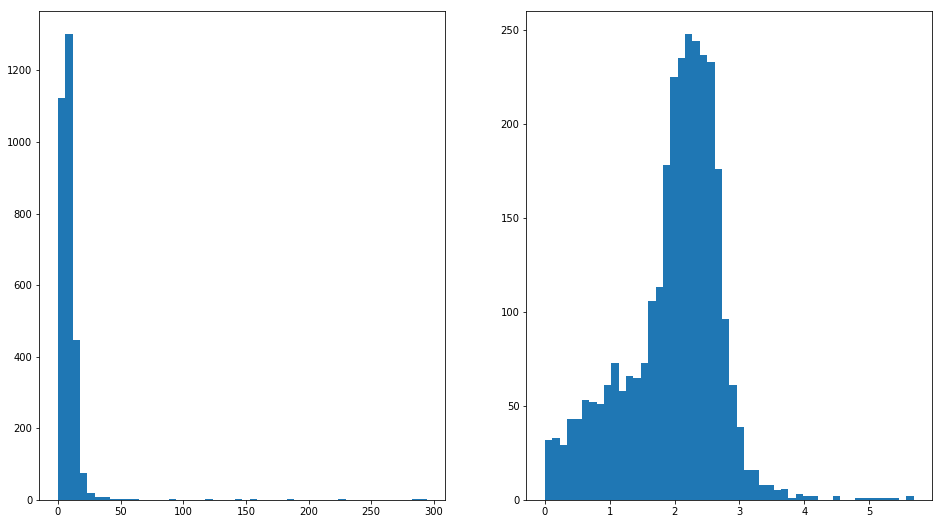

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(16, 9))
ax[0].hist(df_train['popularity'], bins=50)
ax[1].hist(df_train['popularity'].apply(np.log1p), bins=50);

In [93]:
df_train['popularity'] = df_train['popularity'].apply(np.log1p)
df_test['popularity'] = df_test['popularity'].apply(np.log1p)

#### release_date

In [96]:
df_train['release_date'] = pd.to_datetime(df_train['release_date'])

In [ ]:
df_train.drop(['imdb_id', 'poster_path'], axis=1, inplace=True)

In [94]:
df_train.head()

,budget,genres,imdb_id,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,collection_name,has_collection,num_genres,genres_other,genresFamily,genresComedy,genresFantasy,genresAnimation,genresThriller,genresMusic,genresHorror,genresHistory,genresDrama,genresCrime,genresScience Fiction,genresAction,genresAdventure,genresMystery,genresRomance,num_production_companies,production_companies_other,production_companiesFox Searchlight Pictures,production_companiesUnited Artists,production_companiesTwentieth Century Fox Film Corporation,production_companiesColumbia Pictures Corporation,production_companiesUniversal Pictures,production_companiesFox 2000 Pictures,production_companiesAmblin Entertainment,production_companiesTouchstone Pictures,production_companiesColumbia Pictures,...,castKeith David,castJohn Turturro,castRichard Jenkins,castSylvester Stallone,castRobert De Niro,castJason Statham,castMel Gibson,castRobert Duvall,castBill Murray,castSamuel L. Jackson,castLiam Neeson,castJohn Goodman,castGeorge Clooney,num_crew,crew_other,crewBob Weinstein,crewTricia Wood,crewAvy Kaufman,crewJanet Hirshenson,crewJames Horner,crewLuc Besson,crewJohn Debney,crewJohn Papsidera,crewKerry Barden,crewHans Zimmer,crewJames Newton Howard,crewSteven Spielberg,crewJerry Goldsmith,crewRobert Rodriguez,crewFrancis Ford Coppola,crewJane Jenkins,crewDeborah Aquila,crewFrancine Maisler,crewHarvey Weinstein,crewMary Vernieu,log_revenue,log_budget,has_homepage,lang_other,lang_en,lang_fr,lang_ru,lang_es,lang_hi,lang_ja,lang_it,lang_cn,lang_ko,lang_zh
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,14000000,[Comedy],tt2637294,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",2.024905,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[Paramount Pictures, United Artists, Metro-Gol...",[United States of America],2/20/15,93.0,[English],Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[time travel, sequel, hot tub, duringcreditsst...","[Rob Corddry, Craig Robinson, Clark Duke, Adam...","[Kelly Cantley, Steve Pink, Josh Heald, Josh H...",12314651,Hot Tub Time Machine Collection,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,72,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.326300,16.454568,0,0,1,0,0,0,0,0,0,0,0,0
2,40000000,"[Comedy, Drama, Family, Romance]",tt0368933,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,2.224504,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,[Walt Disney Pictures],[United States of America],8/6/04,113.0,[English],Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[coronation, duty, marriage, falling in love]","[Anne Hathaway, Julie Andrews, H√©ctor Elizond...","[Garry Marshall, Charles Minsky, John Debney, ...",95149435,The Princess Diaries Collection,1,4,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,9,8,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,18.370959,17.504390,0,0,1,0,0,0,0,0,0,0,0,0
3,3300000,[Drama],tt2582802,Whiplash,"Under the direction of a ruthless instructor, ...",4.178992,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[Bold Films, Blumhouse Productions, Right of W...",[United States of America],10/10/14,105.0,[English],Released,The road to greatness can take you to the edge.,Whiplash,"[jazz, obsession, conservatory, music teacher,...","[Miles Teller, J.K. Simmons, Melissa Benoist, ...","[Terri Taylor, Richard Henderson, Jeffrey Stot...",13092000,NaN,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,64,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.387512,15.009433,1,0,1,0,0,0,0,0,0,0,0,0
4,1200000,"[Thriller, Drama]",tt1821480,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,1.429099,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,[],[

# EDA

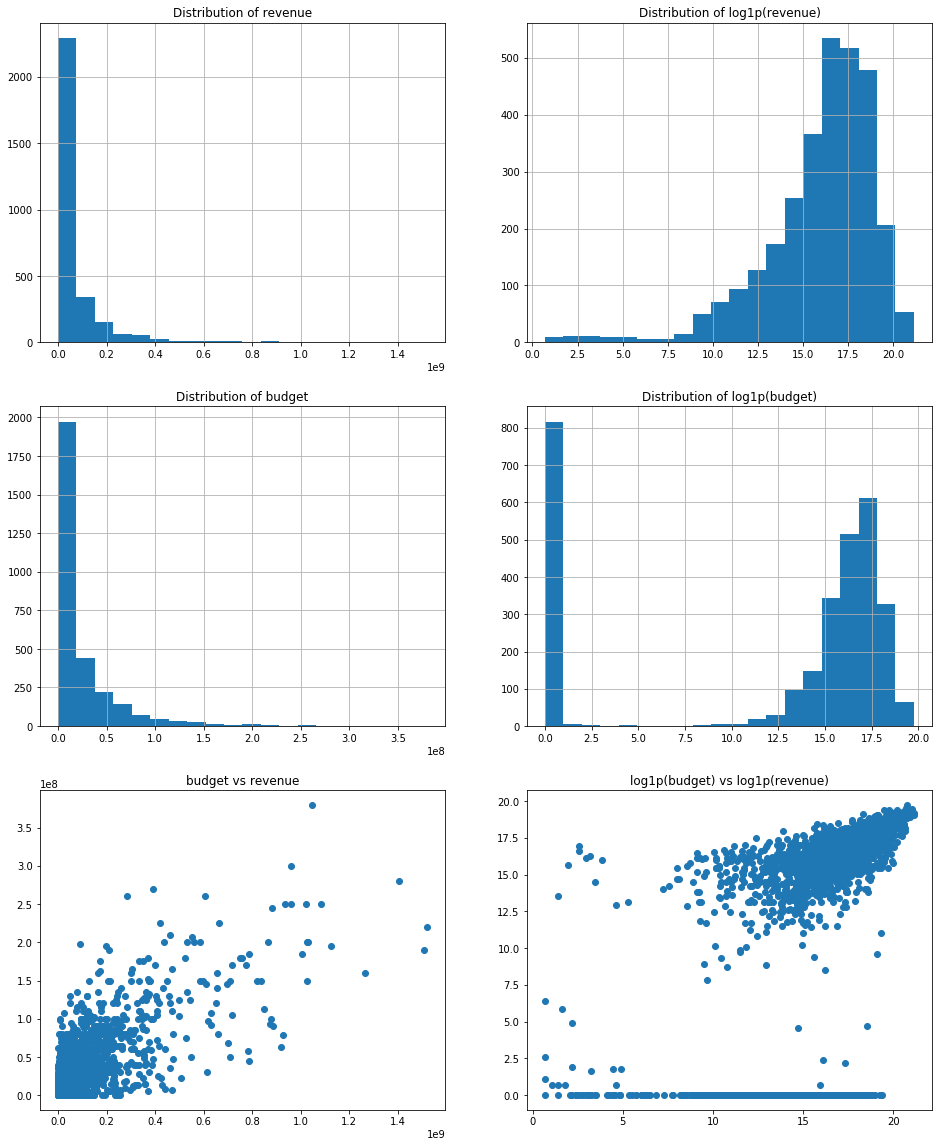

In [48]:
fig, ax = plt.subplots(3, 2, figsize=(16, 20))
ax = ax.flatten()
df_train['revenue'].hist(bins=20, ax=ax[0])
df_train['revenue'].apply(np.log1p).hist(bins=20, ax=ax[1])
df_train['budget'].hist(bins=20, ax=ax[2])
df_train['budget'].apply(np.log1p).hist(bins=20, ax=ax[3])
ax[4].scatter(df_train['revenue'], df_train['budget'])
ax[5].scatter(df_train['revenue'].apply(np.log1p), df_train['budget'].apply(np.log1p))
ax[0].set_title('Distribution of revenue')
ax[1].set_title('Distribution of log1p(revenue)')
ax[2].set_title('Distribution of budget')
ax[3].set_title('Distribution of log1p(budget)')
ax[4].set_title('budget vs revenue')
ax[5].set_title('log1p(budget) vs log1p(revenue)');

Create logarithmic columns for revenue and budget.

In [50]:
df_train['log_revenue'] = df_train['revenue'].apply(np.log1p)
df_train['log_budget'] = df_train['budget'].apply(np.log1p)
df_test['log_budget'] = df_test['budget'].apply(np.log1p)